In [29]:
# relevant imports
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from matplotlib import rcParams
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
import os
import seaborn as sns
import sklearn as sk
import math
import pandas as pd
import pickle
import glob
import scipy as sci

In [9]:
# change the working directory to be the timecourse data
top_dir = '/gpfs/scratch/linjjiang/eye_data/fMRI/results/'
#'/mnt/Data1/linjdata1/vswmda/eye_data/fMRI/results/'
os.chdir(top_dir)


In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_eye_ts(averaged_binned_data,cond_all):
    # Define a color palette for the conditions
    #colors = plt.cm.viridis(np.linspace(0, 1, 8))

    # Define a color palette for the conditions using a distinct color map
    colors = [[61/255, 90/255, 128/255],
        [61/255, 90/255, 128/255],
        [166/255, 75/255, 53/255],
        [166/255, 75/255, 53/255],
        [61/255, 90/255, 128/255],
        [61/255, 90/255, 128/255],
        [166/255, 75/255, 53/255],
        [166/255, 75/255, 53/255]]#plt.cm.tab10(np.linspace(0, 1, 8))
    markers = ['o','v','o','v','o','v','o','v']
    alpha = [1,1,1,1,0.5,0.5,0.5,0.5]

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    bin_size = 100 # ms
    for c,condition in enumerate(cond_all):
        x = averaged_binned_data[condition][:, 0]
        y = averaged_binned_data[condition][:, 1]
        z = np.arange(0, averaged_binned_data[condition].shape[0]*bin_size, bin_size)  # Binned time points from 0 to 8000 ms
        ax.plot(x, y, z,color=colors[c],  alpha = alpha[c],label=condition) #marker=markers[condition],

    ax.set_xlabel('X Gaze Location')
    ax.set_ylabel('Y Gaze Location')
    ax.set_zlabel('Time (ms)')
    ax.set_title('3D Binned Gaze Time Courses Averaged Across Valid Trials for 8 Conditions')
    ax.legend(cond_all)
    ax.grid(True)

    plt.show()
    fig = plt.gcf()
    return fig

In [11]:
# calculate euclidean distance between timecourses of different conditions
def calculate_dissimilarity(cond_data):
    
    # Calculate the averaged binned data for each condition
    averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}

    # Optionally, convert the lists back to numpy arrays
    for cond in averaged_binned_data:
        averaged_binned_data[cond] = np.array(averaged_binned_data[cond])
    
    # Extract conditions from the dictionary keys
    conditions = list(averaged_binned_data.keys())
    num_conditions = len(conditions)
    time_points = next(iter(averaged_binned_data.values())).shape[0]
    
    # Initialize an array to store the Euclidean distances
    # Shape: (num_conditions, num_conditions, time_points)
    distances = np.zeros((num_conditions, num_conditions, time_points))

    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            if cond1 != cond2:
                for t in range(time_points):
                    x_diff = averaged_binned_data[cond1][t, 0] - averaged_binned_data[cond2][t, 0]
                    y_diff = averaged_binned_data[cond1][t, 1] - averaged_binned_data[cond2][t, 1]
                    distances[i, j, t] = np.sqrt(x_diff**2 + y_diff**2)

    # Aggregate the distances across the time points
    mean_distances = np.nanmean(distances, axis=2)
    mean_distances_all = np.nanmean(mean_distances)

    return mean_distances, mean_distances_all

In [12]:
def perm_distance(cond_data,num_permutations):
    
    # Calculate the dissimilarity matrix for the actual data
    rdm, mean_rdm = calculate_dissimilarity(cond_data)
    
    conditions = list(averaged_binned_data.keys())
    num_conditions = len(conditions)
    num_trials = next(iter(averaged_binned_data.values())).shape[0]
        
    # Initialize an array to store the permuted dissimilarity values
    permuted_rdm = np.zeros((num_permutations, num_conditions, num_conditions))
    mean_permuted_rdm = np.zeros((num_permutations, 1))

    # Calculate the p-values
    p_values = np.zeros((num_conditions, num_conditions))

    
    for i in range(num_permutations):
        # Flatten all data across conditions for shuffling
        all_data = np.concatenate([cond_data[cond] for cond in cond_all], axis=0)

        # Shuffle the trials across conditions
        # Multi-dimensional arrays are only shuffled along the first axis
        np.random.shuffle(all_data)

        # Reshape the shuffled data back to the original dictionary structure
        shuffled_data = {}
        for j, cond in enumerate(cond_all):
            num_trials = len(cond_data[cond])
            if j == 0:
                start_idx = 0
            else:
                start_idx = end_idx
            end_idx = start_idx + num_trials
            shuffled_data[cond] = all_data[start_idx:end_idx, :]

        # Calculate the dissimilarity matrix for the shuffled data
        permuted_rdm[i],mean_permuted_rdm[i] = calculate_dissimilarity(shuffled_data)

        for cond1 in range(num_conditions):
                for cond2 in range(num_conditions):
                    if cond1 != cond2:
                        actual_value = rdm[cond1, cond2]
                        permuted_values = permuted_rdm[:, cond1, cond2]
                        p_values[cond1, cond2] = np.mean(permuted_values > actual_value)

        p_values_mean = np.sum(mean_permuted_rdm > mean_rdm)/len(mean_permuted_rdm)

    return p_values, p_values_mean

In [13]:

subjects = ['f09','f10','f11','f12','f15','f16','f17','f18','f19']
epochs = ['delay','resp','stim']
exp1_subjects = ['f09','f10','f11','f12','f15','f16']
exp2_subjects = ['f17','f18','f19']

In [14]:
df = pd.DataFrame()

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f09_1


/tmp/ipykernel_9232/270549759.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(eye_data, axis=(1,2))
/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

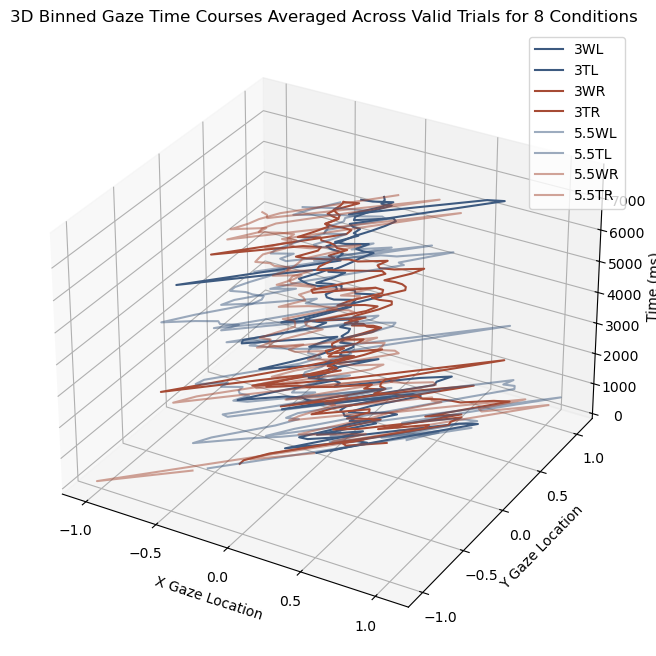

/tmp/ipykernel_9232/2050876832.py:5: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


/gpfs/scratch/linjjiang/eye_data/fMRI/results/f10_2


<Figure size 640x480 with 0 Axes>

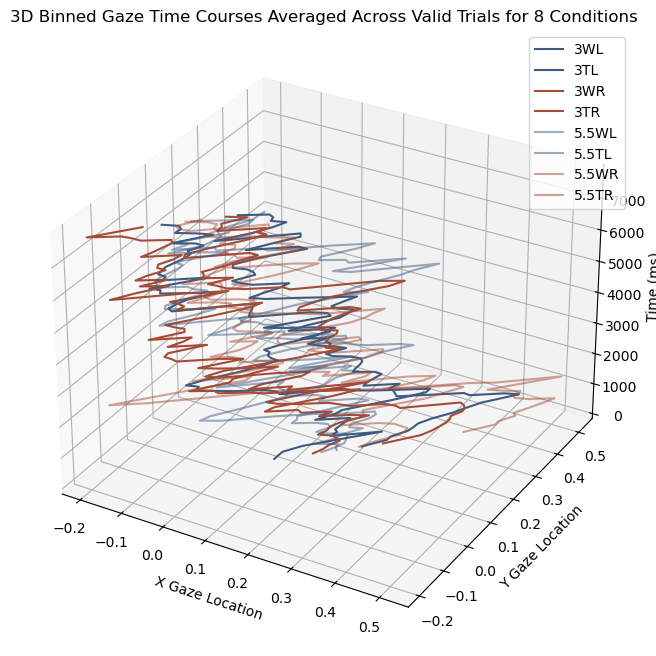

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f10_3


<Figure size 640x480 with 0 Axes>

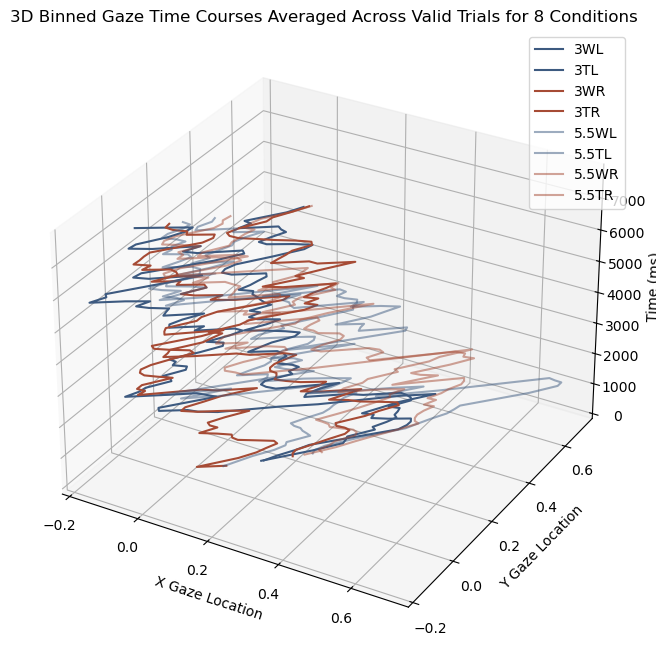

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f11_1


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

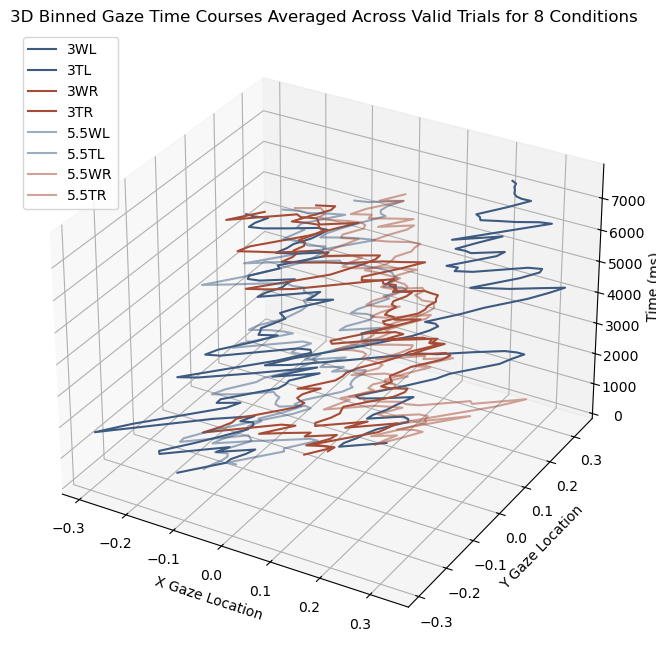

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f11_2


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

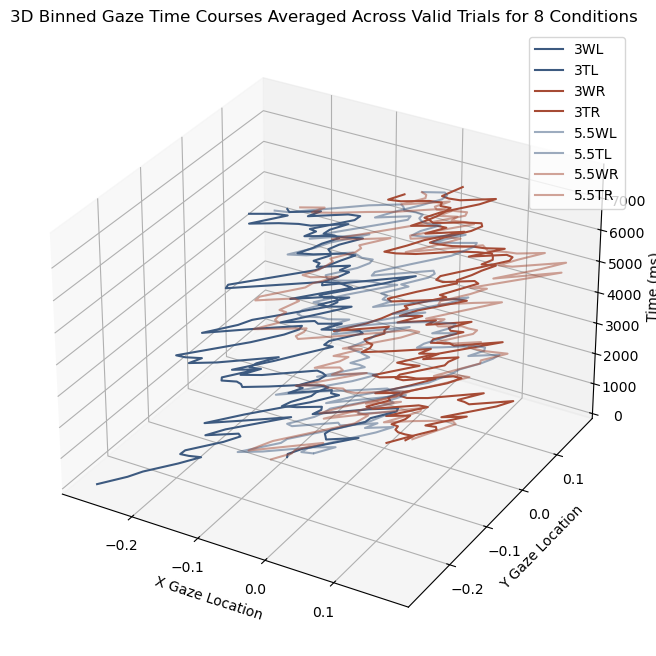

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f12_2


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

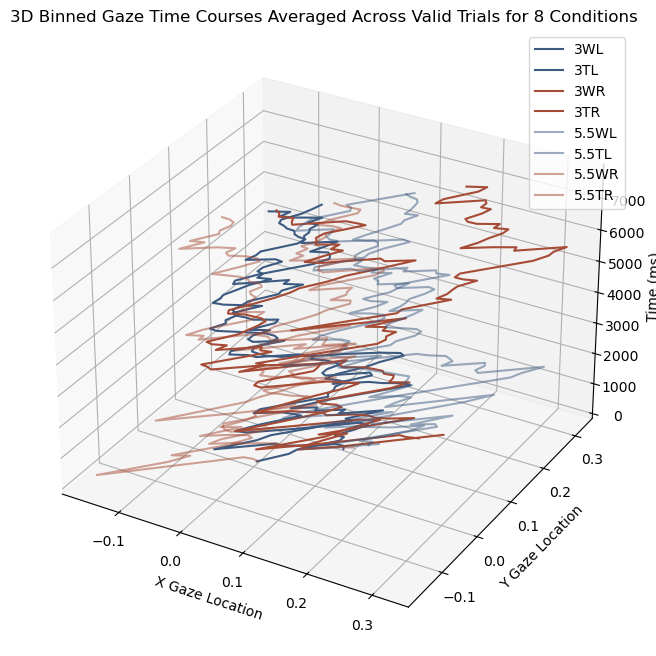

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f12_3


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

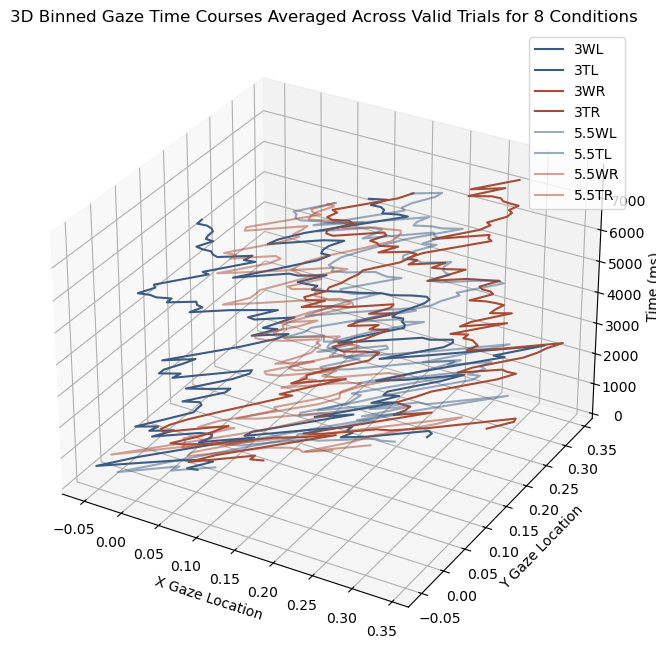

/gpfs/scratch/linjjiang/eye_data/fMRI/results/f15_2


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

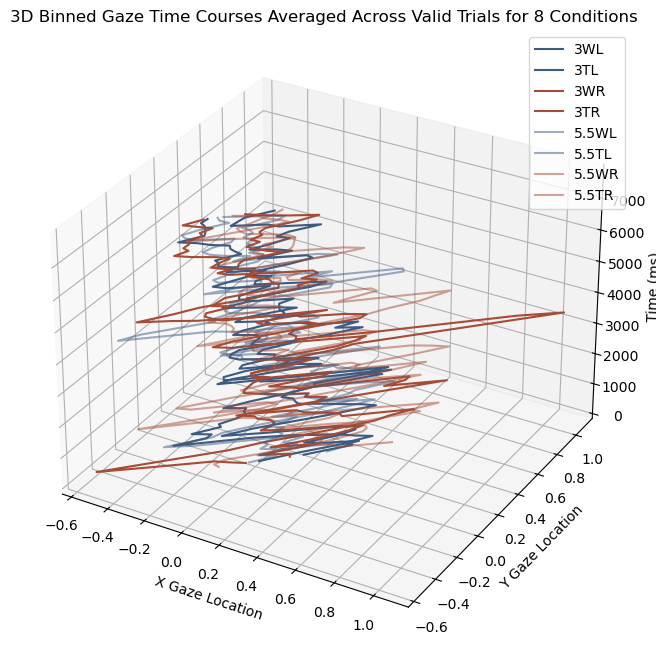

/tmp/ipykernel_9232/2050876832.py:5: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


/gpfs/scratch/linjjiang/eye_data/fMRI/results/f15_3


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)
/tmp/ipykernel_9232/270549759.py:72: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


<Figure size 640x480 with 0 Axes>

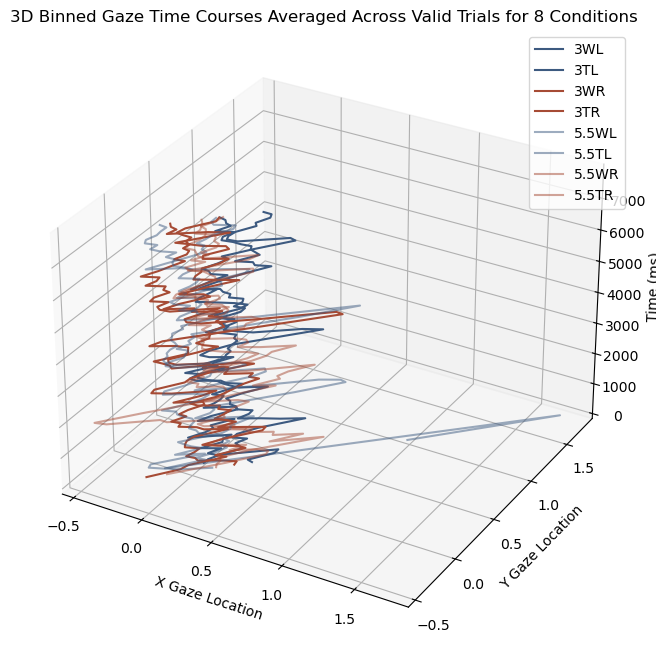

/tmp/ipykernel_9232/2050876832.py:5: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


/gpfs/scratch/linjjiang/eye_data/fMRI/results/f16_1


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

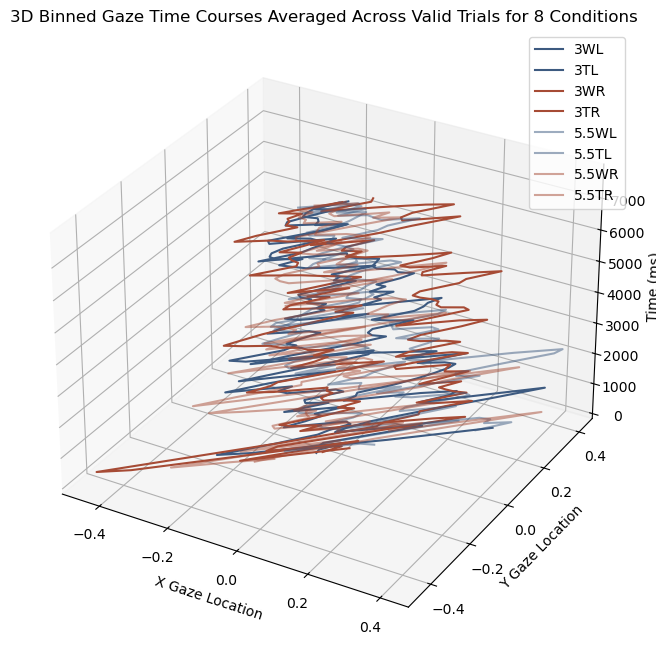

/tmp/ipykernel_9232/2050876832.py:5: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


/gpfs/scratch/linjjiang/eye_data/fMRI/results/f16_2


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


<Figure size 640x480 with 0 Axes>

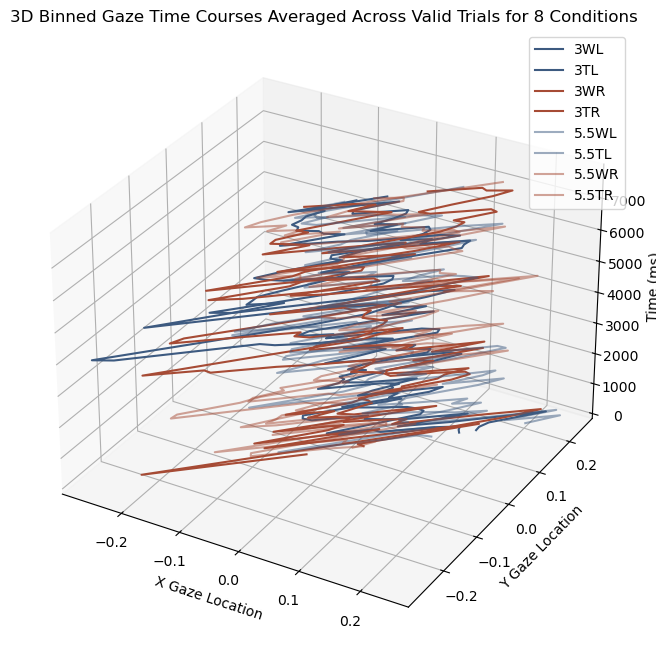

/tmp/ipykernel_9232/2050876832.py:5: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


/gpfs/scratch/linjjiang/eye_data/fMRI/results/f17_2


/tmp/ipykernel_9232/270549759.py:59: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


KeyError: '3WL'

<Figure size 640x480 with 0 Axes>

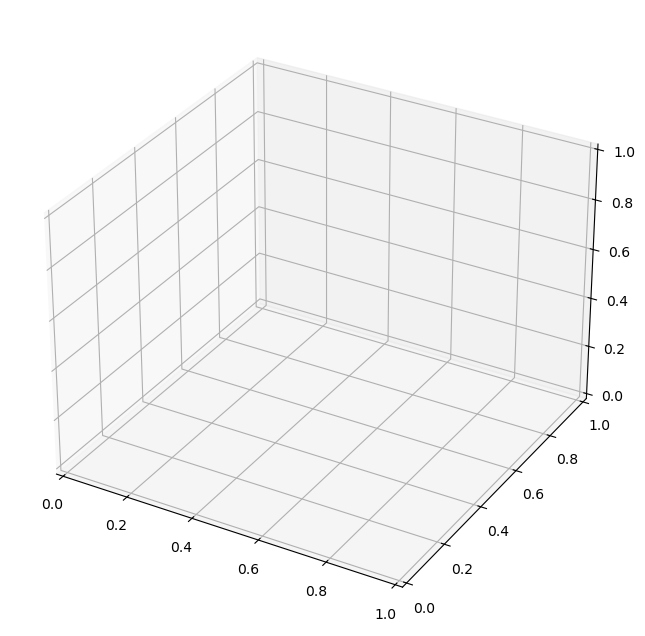

In [15]:
for epoch in [0,1,2]:
    for subject in subjects:
        # Get all folders starting with "f"
        folders = [folder for folder in glob.glob(os.path.join(top_dir, subject+'*')) if os.path.isdir(folder)]

        # Filter folders to include only those containing 'rsa.mat'
        filtered_folders = [folder for folder in folders if os.path.isfile(os.path.join(folder, 'rsa_'+epochs[epoch]+'.mat'))]
        filtered_folders = sorted(filtered_folders)
        
        #print(filtered_folders)
        for folder in filtered_folders[0:2]: # we will only consider the first two sessions
            # load data
            data = io.matlab.loadmat(folder+'/rsa_'+epochs[epoch]+'.mat')
            print(folder)
            
            # get all the conditions
            cond_all = [data['cond'][0][i][0] for i in range(8)] # 1 x 8
            cond_names = [data['cond_names'][i][0][0] for i in range(len(data['cond_names']))] # 96 x 1
            
            # eye data
            eye_data = data['eye_data']
            
            # get rid of a single dimension
            eye_data = np.squeeze(np.array(eye_data.tolist()))
            
            # how many time points are there
            n_timepoints = eye_data.shape[1]
            
            # Exclude trials with excessive variance
            # Calculate the variance for each trial
            variances = np.nanvar(eye_data, axis=(1,2))

            # Define a threshold for excessive variance (e.g., mean + 3 * std)
            variance_threshold = np.nanmean(variances) + 3 * np.nanstd(variances)

            # Identify trials with variance below the threshold
            valid_trials = variances < variance_threshold

            # Exclude trials with excessive variance
            filtered_data = eye_data[valid_trials]

            # filter trials in cond_names too
            cond_names_valid = [cond_names[i] for i in range(len(valid_trials)) if valid_trials[i]==True]

            
            # Bin the data
            bin_size = 100  # Bin size in ms
            num_bins = n_timepoints // bin_size  # Number of bins

            # Initialize arrays to hold the binned data
            num_valid_trials = filtered_data.shape[0]
            binned_data = np.zeros((num_valid_trials, num_bins, 2))

            # Bin the data
            for trial in range(num_valid_trials):
                for bin_idx in range(num_bins):
                    start_idx = bin_idx * bin_size
                    end_idx = (bin_idx + 1) * bin_size
                    binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)

            # Initialize a dictionary to store binned data for each condition
            cond_data = {cond: [] for cond in set(cond_names_valid)}

            # Group the binned data by condition
            for i, cond in enumerate(cond_names_valid):
                #print(i,cond)
                cond_data[cond].append(binned_data[i,:,:])
    
    
            # Averaged binned data across trials for each condition
            # Calculate the averaged binned data for each condition
            averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}

            # Optionally, convert the lists back to numpy arrays
            for cond in averaged_binned_data:
                averaged_binned_data[cond] = np.array(averaged_binned_data[cond])
            
            # plot and save the timecourse
            plt.clf()
            fig = plot_eye_ts(averaged_binned_data,cond_all)
            fig.savefig(os.path.join(folder,epochs[epoch]+'_timecourse_by_cond.png'),bbox_inches = 'tight')
            
            # calculate dissimilarity value
            # Calculate the dissimilarity matrix for the actual data
            mean_distances, mean_distances_all = calculate_dissimilarity(cond_data)
            
            # Calculate dissimilarity value for permuted data
            p_values, p_values_mean = perm_distance(cond_data,100)

            # store the dissimilarity value and p values
            df = pd.concat([df,pd.DataFrame({'subj':[subject],
                                          'epoch':[epochs[epoch]],
                                          'session':[folder.replace(top_dir, "")],
                                          'rdm':[mean_distances],
                                          'dis_val':[mean_distances_all],
                                          'p_val_rdm':[p_values],
                                          'p_val':[p_values_mean],
                                           'averaged_eye_data':[averaged_binned_data]})],axis=0)
            
            

In [18]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jun 24 18:51:13 2024', '__version__': '1.0', '__globals__': [], 'cond': array([[array(['3WL'], dtype='<U3'), array(['3TL'], dtype='<U3'),
        array(['3WR'], dtype='<U3'), array(['3TR'], dtype='<U3'),
        array(['5.5WL'], dtype='<U5'), array(['5.5TL'], dtype='<U5'),
        array(['5.5WR'], dtype='<U5'), array(['5.5TR'], dtype='<U5')]],
      dtype=object), 'cond_names': array([[array(['5.5WR'], dtype='<U5')],
       [array(['5.5TL'], dtype='<U5')],
       [array(['5.5WL'], dtype='<U5')],
       [array(['5.5WR'], dtype='<U5')],
       [array(['5.5TL'], dtype='<U5')],
       [array(['5.5TR'], dtype='<U5')],
       [array(['5.5TR'], dtype='<U5')],
       [array(['5.5WL'], dtype='<U5')],
       [array(['5.5WR'], dtype='<U5')],
       [array(['5.5TL'], dtype='<U5')],
       [array(['5.5WR'], dtype='<U5')],
       [array(['5.5WL'], dtype='<U5')],
       [array(['5.5TL'], dtype='<U5')],
       [array(['5.5TR'], d

In [35]:
a = averaged_binned_data['5.5WL']
b = averaged_binned_data['5.5WR']
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r
out = corr2(a,b)

print(out,a.shape,b.shape)

0.032102313119269275 (80, 2) (80, 2)


In [ ]:
# https://www.mathworks.com/help/images/ref/corr2.html

In [32]:
print(out)

[[ 1.88583223e-03  3.77166445e-03  1.88583223e-03]
 [ 2.93698098e-03  5.87396195e-03  2.93698098e-03]
 [ 1.35153095e-03  2.70306190e-03  1.35153095e-03]
 [ 3.96363144e-03  7.92726287e-03  3.96363144e-03]
 [ 2.72301868e-03  5.44603736e-03  2.72301868e-03]
 [-6.35835451e-03 -1.27167090e-02 -6.35835451e-03]
 [-2.87699460e-03 -5.75398921e-03 -2.87699460e-03]
 [ 4.72799562e-03  9.45599124e-03  4.72799562e-03]
 [ 1.12473435e-03  2.24946870e-03  1.12473435e-03]
 [ 9.95468833e-03  1.99093767e-02  9.95468833e-03]
 [ 1.75299212e-02  3.50598424e-02  1.75299212e-02]
 [ 1.82076211e-02  3.64152422e-02  1.82076211e-02]
 [ 8.19993933e-03  1.63998787e-02  8.19993933e-03]
 [ 6.19727426e-03  1.23945485e-02  6.19727426e-03]
 [ 1.82124824e-02  3.64249647e-02  1.82124824e-02]
 [ 1.29979242e-02  2.59958485e-02  1.29979242e-02]
 [ 9.46887446e-03  1.89377489e-02  9.46887446e-03]
 [ 2.15683915e-02  4.31367830e-02  2.15683915e-02]
 [ 1.98964345e-02  3.97928691e-02  1.98964345e-02]
 [ 1.34612501e-02  2.69225002e-

In [471]:
# save df
with open(os.path.join('eye_dis_val.pkg'),'wb') as f:
    pickle.dump(df,f)

## Plot averaged timecourse across participants

In [480]:
## Plot averaged timecourse across participants
def calculate_average_timecourse(df):
    conditions = df.iloc[0].keys()
    avg_timecourses = {}

    for condition in conditions:
        all_timecourses = np.array([df.iloc[i][condition] for i in range(len(df))])
        avg_timecourse = np.mean(all_timecourses, axis=0)
        avg_timecourses[condition] = avg_timecourse

    return avg_timecourses

<Figure size 432x288 with 0 Axes>

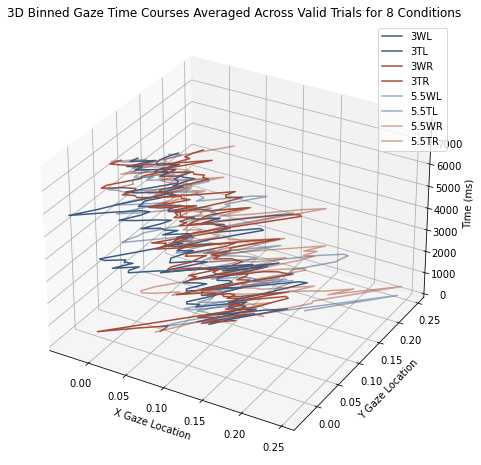

<Figure size 432x288 with 0 Axes>

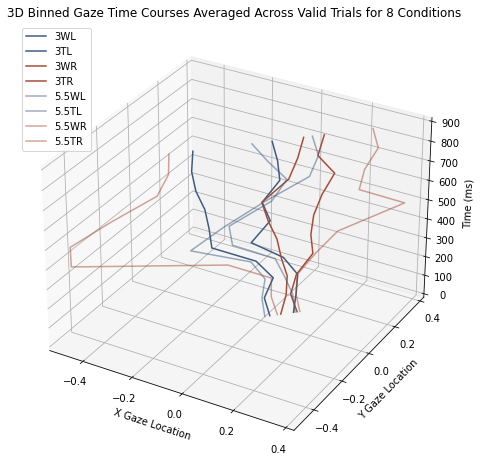

<Figure size 432x288 with 0 Axes>

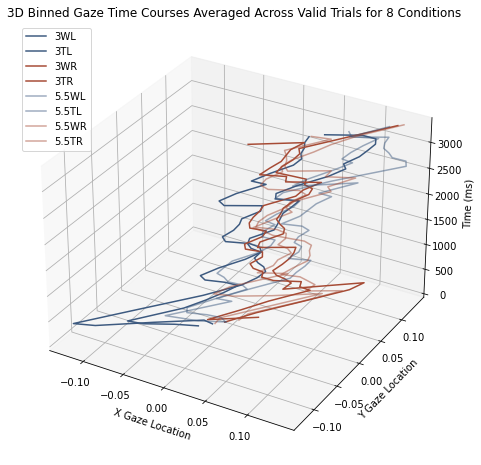

<Figure size 432x288 with 0 Axes>

In [482]:
for epoch in [0,1,2]:
    avg_data = df[df['epoch']== epochs[epoch]]['averaged_eye_data']

    # Calculate the average timecourse
    average_timecourses = calculate_average_timecourse(avg_data)
    
    # plot and save the timecourse
    plt.clf()
    fig = plot_eye_ts(average_timecourses,cond_all)
    fig.savefig(os.path.join(epochs[epoch]+'_timecourse_by_cond.png'),bbox_inches = 'tight')

## Plot RDM

In [563]:
def avg_rdm(data):
    all_rdm = np.array([data.iloc[i] for i in range(len(data))])
    avg_rdm = np.nanmean(all_rdm, axis=0)
    return avg_rdm

In [522]:
epochs = ['stim','delay','resp']
print(cond_all)

['3WL', '3TL', '3WR', '3TR', '5.5WL', '5.5TL', '5.5WR', '5.5TR']


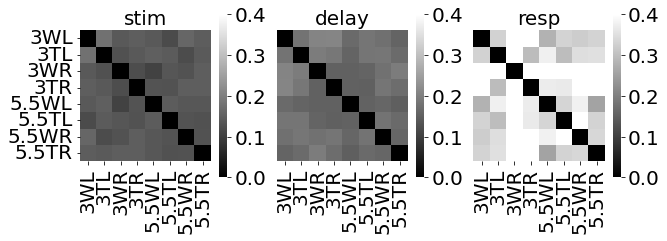

In [556]:
# Plot RDMs
fig, ax = plt.subplots(1,3,figsize=(10,3)) # for six ROIs and 2 sessions per subject
# define sizes of the plot
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 100

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
for epoch in range(3):
    
    data = df[df['epoch']== epochs[epoch]]['rdm']
    RDM_mean = avg_rdm(data)
    
    xl = []
    yl = []
    if epoch == 0: # if it is the 0th (first), 2nd (actually the third), ... plot, we will plot conditions on y
        yl = cond_all
    xl = cond_all # plot conditions on x for all figures

    sns.heatmap(RDM_mean,ax = ax[epoch],cmap='gray',annot=None,cbar=True,square=True,vmin=0, vmax=0.4,
                    xticklabels=xl,
                     yticklabels=yl) #vmin=0, vmax=1,
    #ax[pp].set_title(RDM_mean[pp].rdm_descriptors['roi'][0])
    #if epoch == 0:
    ax[epoch].set_title(epochs[epoch])


#fig.savefig('RDM.png',bbox_inches = 'tight',dpi = 300)


## Plot dissimilarity value

In [538]:
print(df.head(5))

  subj  epoch session                                                rdm  \
0  f10  delay   f10_2  [[0.0, 0.10628542299426993, 0.1383261147859640...   
0  f10  delay   f10_3  [[0.0, 0.15211657441307933, 0.353111026538688,...   
0  f11  delay   f11_1  [[0.0, 0.20559250510612498, 0.1081345348340448...   
0  f11  delay   f11_2  [[0.0, 0.10801129396280748, 0.2366074059406057...   
0  f12  delay   f12_2  [[0.0, 0.07925084452250668, 0.0918750715068401...   

    dis_val                                          p_val_rdm  p_val  \
0  0.135815  [[0.0, 0.76, 0.39, 0.02, 0.22, 0.2, 0.92, 0.18...   0.27   
0  0.173390  [[0.0, 0.53, 0.02, 0.19, 0.22, 0.17, 0.05, 0.3...   0.24   
0  0.143668  [[0.0, 0.26, 0.85, 1.0, 0.96, 0.22, 0.59, 0.26...   0.42   
0  0.105569  [[0.0, 0.39, 0.02, 0.0, 0.72, 0.11, 0.03, 0.41...   0.24   
0  0.110805  [[0.0, 0.85, 0.73, 0.23, 0.99, 0.7, 0.97, 0.27...   0.63   

                                   averaged_eye_data  
0  {'3WL': [[0.20555436366545776, 0.2055543636654

In [542]:
print(df[df['p_val']<= 0.05])

  subj epoch session                                                rdm  \
0  f10  stim   f10_2  [[0.0, 0.2762371282099472, 0.20485409722413367...   
0  f16  stim   f16_1  [[0.0, 0.18082650459586186, 0.1704203238410370...   

    dis_val                                          p_val_rdm  p_val  \
0  0.141414  [[0.0, 0.03, 0.11, 0.39, 0.5, 0.72, 0.1, 0.3],...   0.05   
0  0.141809  [[0.0, 0.05, 0.13, 0.02, 0.1, 0.76, 0.11, 0.27...   0.00   

                                   averaged_eye_data  
0  {'3WL': [[-0.0076954823565838935, -0.007695482...  
0  {'3WL': [[-0.03756196223658893, -0.03756196223...  


In [548]:
print(df[df['epoch']=='stim']['dis_val'].to_numpy().mean())
print(df[df['epoch']=='delay']['dis_val'].to_numpy().mean())
print(df[df['epoch']=='resp']['dis_val'].to_numpy().mean())

0.12011512041969344
0.15042747631286021
0.3480518732642842


In [554]:
data = df[df['epoch']== 'stim']['rdm']
print(avg_rdm(data).mean())

data = df[df['epoch']== 'delay']['rdm']
print(print(avg_rdm(data)))
print(avg_rdm(data).mean())

data = df[df['epoch']== 'resp']['rdm']
print(avg_rdm(data))
print(avg_rdm(data).mean())

0.12011512041969344
[[0.         0.17979145 0.20634872 0.20820112 0.16587343 0.1829364
  0.17575415 0.15690262]
 [0.17979145 0.         0.19385494 0.18679023 0.15725812 0.18333263
  0.1857933  0.16793589]
 [0.20634872 0.19385494 0.         0.15245522 0.15230272 0.15714662
  0.17695971 0.19502545]
 [0.20820112 0.18679023 0.15245522 0.         0.15156441 0.15109687
  0.18374064 0.17154693]
 [0.16587343 0.15725812 0.15230272 0.15156441 0.         0.15413569
  0.1606056  0.14873366]
 [0.1829364  0.18333263 0.15714662 0.15109687 0.15413569 0.
  0.18076001 0.16627174]
 [0.17575415 0.1857933  0.17695971 0.18374064 0.1606056  0.18076001
  0.         0.16056099]
 [0.15690262 0.16793589 0.19502545 0.17154693 0.14873366 0.16627174
  0.16056099 0.        ]]
None
0.15042747631286024
[[0.         0.32887759 0.48682512 0.4004894  0.27887544 0.32988794
  0.32101538 0.32977096]
 [0.32887759 0.         0.59054929 0.2950406  0.37554726 0.29593236
  0.34704915 0.35053682]
 [0.48682512 0.59054929 0.       

<AxesSubplot:xlabel='epoch', ylabel='dis_val'>

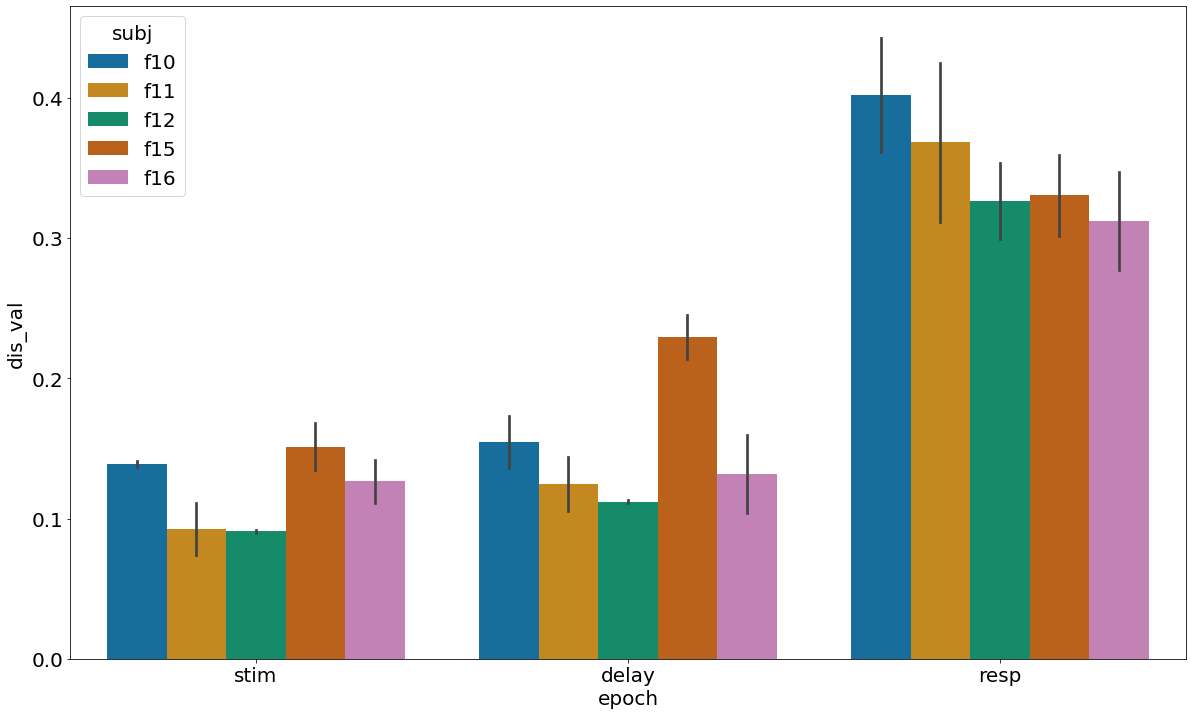

In [540]:
# Plotting
session_palette = sns.color_palette("colorblind", 5)
task_epoch_order = ["stim", "delay", "resp"]
plt.figure(figsize=(20, 12))
#g = sns.FacetGrid(df) #col="epoch", col_order=task_epoch_order, col_wrap=1, height=4, aspect=2
sns.barplot(data=df,x='epoch', y='dis_val', hue='subj', order=task_epoch_order, dodge=True, palette=session_palette) #palette=session_palette
#g.map_dataframe(scatter_and_lines)

## regress on models

In [557]:
# other ways to construct the model (equivalent) - method 2
cond_names = ['3WL', '3TL', '3WR', '3TR', '5.5WL', '5.5TL', '5.5WR', '5.5TR']
rdms_model_temp= rsatoolbox.rdm.rdms.get_categorical_rdm(['0','0','1','1','0','0','1','1'])
rdms_model_space = rsatoolbox.rdm.rdms.get_categorical_rdm(['0','1','0','1','0','1','0','1'])
rdms_model_ecc = rsatoolbox.rdm.rdms.get_categorical_rdm(['0','0','0','0','1','1','1','1'])

model_names = ['TempPat', 'ShapePat', 'EccPat']

# append in one RDMs object

model_rdms = rdms_model_temp
model_rdms.append(rdms_model_space)
model_rdms.append(rdms_model_ecc)

model_rdms.rdm_descriptors['model_names'] = model_names
model_rdms.pattern_descriptors['conds'] = cond_names
#model_rdms.dissimilarity_measure = 'correlation'
models_weight = rsatoolbox.model.ModelWeighted(model_names, model_rdms)

In [568]:
# Permute the data and calculate a baseline
subjects = ['f10','f11','f12','f15','f16']# # need to trouble-shoot f10
epochs = ['stim','delay','resp'] #

In [603]:
df_unique = pd.DataFrame()

In [604]:
## Model regression
for epoch in range(3):
    for subject in subjects:
        
        data = df[df['epoch']== epochs[epoch]]['rdm']
        RDM = avg_rdm(data)
        RDM = RDM[None, :, :]
        rdms = rsatoolbox.rdm.RDMs(RDM,
                            rdm_descriptors={'epoch':[epochs[epoch]],'subject':subject},
                            pattern_descriptors={'conds':cond_all})

        

        # specify the fitter
        fitter = rsatoolbox.model.fitter.Fitter(rsatoolbox.model.fitter.fit_regress) #fit_optimize #fit_regress 
        
        theta= fitter(models_weight, rdms,method='cosine') #cosine #method='cosine'
        df_unique = pd.concat([df_unique,pd.DataFrame({'model': model_names, 
                                             'theta': theta, 
                                             'subj': subject,
                                              'epoch': epochs[epoch],
                                             'rdm': rdms})], axis=0) 

In [605]:
print(df_unique)

      model     theta subj  epoch  \
0   TempPat  0.543378  f10   stim   
1  ShapePat  0.603840  f10   stim   
2    EccPat  0.583196  f10   stim   
0   TempPat  0.543378  f11   stim   
1  ShapePat  0.603840  f11   stim   
2    EccPat  0.583196  f11   stim   
0   TempPat  0.543378  f12   stim   
1  ShapePat  0.603840  f12   stim   
2    EccPat  0.583196  f12   stim   
0   TempPat  0.543378  f15   stim   
1  ShapePat  0.603840  f15   stim   
2    EccPat  0.583196  f15   stim   
0   TempPat  0.543378  f16   stim   
1  ShapePat  0.603840  f16   stim   
2    EccPat  0.583196  f16   stim   
0   TempPat  0.587334  f10  delay   
1  ShapePat  0.586321  f10  delay   
2    EccPat  0.557912  f10  delay   
0   TempPat  0.587334  f11  delay   
1  ShapePat  0.586321  f11  delay   
2    EccPat  0.557912  f11  delay   
0   TempPat  0.587334  f12  delay   
1  ShapePat  0.586321  f12  delay   
2    EccPat  0.557912  f12  delay   
0   TempPat  0.587334  f15  delay   
1  ShapePat  0.586321  f15  delay   
2

In [606]:
# save df
with open(os.path.join('eye_regress.pkg'),'wb') as f:
    pickle.dump(df_unique,f)

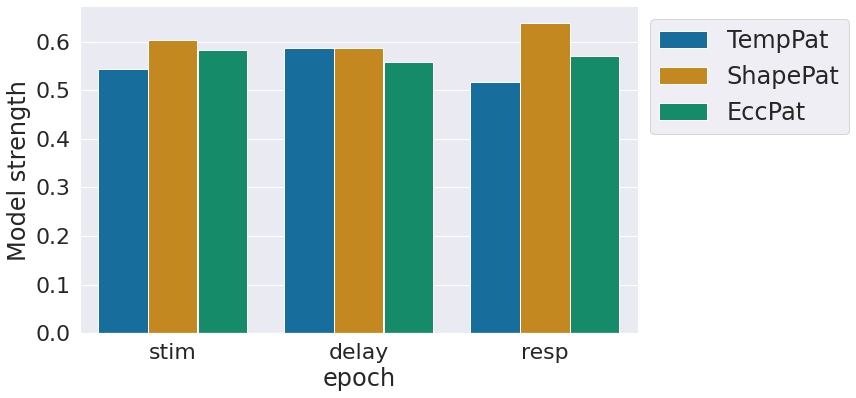

In [621]:
# averaged across participants and sessions
#epoch_all = df_all['epoch'].to_list()
epoch_uniq = ['stim','delay', 'resp']

#for i_epoch in epoch_uniq:
plt.clf()
sns.set(rc={'figure.figsize':(10,6),'font.size':20, 'axes.labelsize':24, 'axes.titlesize':24,'figure.titlesize':24, 'xtick.labelsize': 22, 'ytick.labelsize': 22,'legend.fontsize': 24})

#data = df_unique[df_unique['epoch'] == i_epoch] #and df_all['roi'] == i_roi
ax = sns.barplot(data=df_unique, x="epoch", y="theta", hue='model', palette="colorblind",ci="sd")

plt.legend(bbox_to_anchor=(1, 1)) #mode = "expand",ncol=len(df_all.columns), #loc="lower left", 
#plt.xlabel('Model')
plt.ylabel('Model strength')
#plt.title(i_epoch)
sns.despine()
fig = ax.get_figure()
    #fig.savefig('regression_'+i_epoch+'.png',bbox_inches = 'tight') # dpi = 

In [5]:
# change the working directory to be the timecourse data
top_dir = '/mnt/Data1/linjdata1/vswmda/eye_data/fMRI/results/'
os.chdir(top_dir)

In [12]:



print(folders)
print(filtered_folders)

['/mnt/Data1/linjdata1/vswmda/eye_data/fMRI/results/f09_1']
['/mnt/Data1/linjdata1/vswmda/eye_data/fMRI/results/f09_1']


In [36]:
# load the matlab file
data = io.matlab.loadmat(filtered_folders[0]+'/rsa.mat')

In [37]:
print(data['eye_data'].shape)
print(data['eye_data_reorder'].shape)
print(data['cond'].shape)
print(data['cond_names'].shape)
print(data['run_name'].shape)
print(data['eye_data_reorder'][0,0].shape)
print(data['eye_data_reorder'][0,0])

(96, 1)
(12, 8)
(1, 8)
(96, 1)
(96, 1)
(8000, 2)
[[       nan        nan]
 [       nan        nan]
 [       nan        nan]
 ...
 [0.13609532 0.13609532]
 [0.13332878 0.13332878]
 [0.13074037 0.13074037]]


In [314]:
cond_all = [data['cond'][0][i][0] for i in range(8)]
print(cond_all)

['3WL', '3TL', '3WR', '3TR', '5.5WL', '5.5TL', '5.5WR', '5.5TR']


In [277]:
cond_names = [data['cond_names'][i][0][0] for i in range(len(data['cond_names']))]
print(cond_names)
print(len(cond_names))

['3WR', '3TL', '3WL', '3WR', '3TL', '3TR', '3TR', '3WL', '3WR', '3TL', '3WR', '3WL', '3TL', '3TR', '3WL', '3TR', '5.5WL', '5.5TR', '5.5WR', '5.5TL', '5.5WR', '5.5TL', '5.5WL', '5.5TR', '5.5WL', '5.5WR', '5.5TL', '5.5WR', '5.5TR', '5.5TL', '5.5TR', '5.5WL', '3TL', '3TR', '3WR', '3TL', '3WR', '3WL', '3WL', '3TR', '3WL', '3TR', '3WL', '3TR', '3WR', '3TL', '3WR', '3TL', '5.5WR', '5.5WL', '5.5WL', '5.5TR', '5.5WL', '5.5WR', '5.5TR', '5.5TL', '5.5WR', '5.5TL', '5.5TR', '5.5TL', '5.5WL', '5.5WR', '5.5TL', '5.5TR', '5.5TR', '5.5WL', '5.5TR', '5.5TL', '5.5WL', '5.5WR', '5.5TL', '5.5WR', '5.5WL', '5.5TR', '5.5TR', '5.5TL', '5.5WR', '5.5WL', '5.5TL', '5.5WR', '3WL', '3TR', '3TL', '3TR', '3WR', '3TL', '3WR', '3WL', '3TR', '3WL', '3TL', '3WR', '3TL', '3WR', '3TR', '3WL']
96


In [38]:
eye_data_reorder[:,0][0]

array([[       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       ...,
       [0.13609532, 0.13609532],
       [0.13332878, 0.13332878],
       [0.13074037, 0.13074037]])

In [151]:
eye_data_reorder = data['eye_data_reorder']

In [230]:
eye_data = data['eye_data']

In [241]:
gaze_data = np.squeeze(np.array(eye_data.tolist()))
print(gaze_data.shape)

(96, 8000, 2)


In [246]:
# Calculate the variance for each trial
variances = np.nanvar(gaze_data, axis=(1,2))
print(variances.shape)
print(variances)

# Determine the maximum variance for each trial across conditions
max_variances = np.nanmax(variances, axis=0)  # Shape: (12,)
print(max_variances)

# Define a threshold for excessive variance (e.g., mean + 3 * std)
variance_threshold = np.nanmean(variances) + 3 * np.nanstd(variances)
print(variance_threshold)

# Identify trials with variance below the threshold
valid_trials = variances < variance_threshold

# Exclude trials with excessive variance
filtered_data = gaze_data[valid_trials]

print(valid_trials)
print(np.sum(valid_trials))

(96,)
[3.48315594e-02 3.98456672e-02 1.07640483e-01 1.50044489e-01
 6.60222166e-02 7.68403825e-02 8.93214878e-02 4.02803083e-02
 3.30744022e-01 3.78105224e-01 3.29432773e-01 1.49595281e-01
 5.83291209e-01 5.59775072e-01 2.81396973e-01 4.21039678e-01
 1.39467624e-01 1.62425964e-01 2.43805735e-01 1.28779170e+00
 1.54280657e-01 1.82373953e-01 2.42761927e-01 7.06059917e-02
 4.60241138e-01 7.49725097e-01 1.97991968e-01 5.37906766e-01
 4.62801570e-02 5.30273225e-01 5.93050188e-02 1.28132024e-01
 1.13030553e-01 6.98929810e-01 1.74662610e-01 6.53558246e-02
 9.40384823e-02 5.58518625e-02 1.77622028e-01 1.02452098e-01
 5.83053059e-01 3.76366724e+01 3.81879250e-02 2.12995035e-01
 6.11164107e-01 1.87403818e-01 7.20940354e-02 1.02102776e-01
 8.43155312e-02 4.31328320e-01 1.16222144e+00 6.78645498e-01
 1.13714227e-02 1.93964523e-01 9.49475750e-02 7.34060512e-01
 1.81963504e+00 2.00354328e-01 2.07651703e+00 1.31918586e-01
 8.73983030e-01 5.48584652e-01 5.05177728e-01 1.34318787e-01
 4.17040934e-02 2.

/tmp/ipykernel_125423/3788856453.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(gaze_data, axis=(1,2))


In [259]:
# Parameters
bin_size = 100  # Bin size in ms
num_bins = 8000 // bin_size  # Number of bins

# Initialize arrays to hold the binned data
num_valid_trials = filtered_data.shape[0]
binned_data = np.zeros((num_valid_trials, num_bins, 2))

# Bin the data
for trial in range(num_valid_trials):
    for bin_idx in range(num_bins):
        start_idx = bin_idx * bin_size
        end_idx = (bin_idx + 1) * bin_size
        binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


/tmp/ipykernel_125423/2368398955.py:14: RuntimeWarning: Mean of empty slice
  binned_data[trial, bin_idx, :] = np.nanmean(filtered_data[trial, start_idx:end_idx, :], axis=0)


In [262]:
print(binned_data.shape)
print(binned_data[0,:,0])

(94, 80, 2)
[ 0.08777712  0.10146002  0.06513792         nan         nan -0.14671811
 -0.17998099 -0.17201571 -0.15489016  0.17098381  0.28581575  0.26376655
  0.15777384 -0.13069142 -0.10423555  0.04827218  0.23073231  0.25031791
  0.28189229  0.26245393  0.22104334  0.17785392  0.07483672 -0.56412294
 -0.3921664  -0.07549416 -0.05370417 -0.05307557 -0.01158313  0.02598169
  0.66338591         nan         nan         nan  0.08793406  0.03067489
 -0.29524297 -0.2514166  -0.21472678 -0.15088563 -0.14753194 -0.11125187
 -0.07640894 -0.02036263  0.01989199  0.11005846  0.1938024   0.15840606
  0.08944439  0.11998152  0.12052628  0.27778712  0.2720929   0.18621505
 -0.01457892 -0.02878323  0.02272335  0.03465891  0.02695034  0.00676032
 -0.01787115 -0.14233237 -0.2192743  -0.14143448 -0.04993685  0.05902567
  0.06797572  0.04834965  0.02946515  0.03749332  0.02710761 -0.04187042
 -0.0059539   0.11341264  0.08247363  0.05450033 -0.21896847 -0.26986459
  0.11844589  0.11460406]


In [287]:
# get rid of trials in cond_names too
cond_names_valid = [cond_names[i] for i in range(len(valid_trials)) if valid_trials[i]==True]
print(len(cond_names_valid))
print(cond_names_valid)

94
['3WR', '3TL', '3WL', '3WR', '3TL', '3TR', '3TR', '3WL', '3WR', '3TL', '3WR', '3WL', '3TL', '3TR', '3WL', '3TR', '5.5WL', '5.5TR', '5.5WR', '5.5TL', '5.5WR', '5.5TL', '5.5WL', '5.5TR', '5.5WL', '5.5WR', '5.5TL', '5.5WR', '5.5TR', '5.5TL', '5.5TR', '5.5WL', '3TL', '3TR', '3WR', '3TL', '3WR', '3WL', '3WL', '3TR', '3WL', '3WL', '3TR', '3WR', '3TL', '3WR', '3TL', '5.5WR', '5.5WL', '5.5WL', '5.5TR', '5.5WL', '5.5WR', '5.5TR', '5.5TL', '5.5WR', '5.5TL', '5.5TR', '5.5TL', '5.5WL', '5.5WR', '5.5TL', '5.5TR', '5.5TR', '5.5WL', '5.5TR', '5.5TL', '5.5WL', '5.5WR', '5.5TL', '5.5WR', '5.5TR', '5.5TR', '5.5TL', '5.5WR', '5.5WL', '5.5TL', '5.5WR', '3WL', '3TR', '3TL', '3TR', '3WR', '3TL', '3WR', '3WL', '3TR', '3WL', '3TL', '3WR', '3TL', '3WR', '3TR', '3WL']


In [298]:
print(binned_data[0,:,:].shape)

(80, 2)


In [348]:
# Initialize a dictionary to store binned data for each condition
cond_data = {cond: [] for cond in set(cond_names_valid)}

# Group the binned data by condition
for i, cond in enumerate(cond_names_valid):
    #print(i,cond)
    cond_data[cond].append(binned_data[i,:,:])

In [343]:
print(averaged_binned_data['3WL'].shape)
print(len(cond_data['5.5WL']))

(80, 2)
11


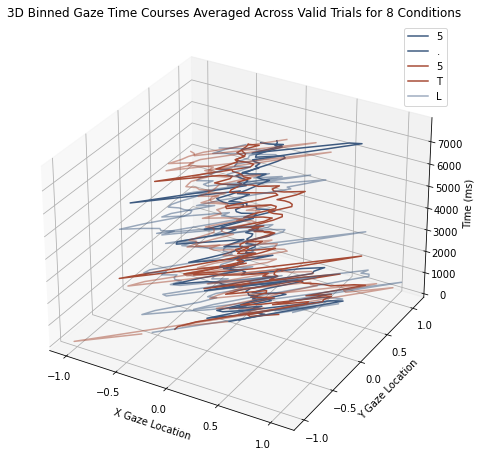

In [316]:
from mpl_toolkits.mplot3d import Axes3D

# Define a color palette for the conditions
#colors = plt.cm.viridis(np.linspace(0, 1, 8))

# Define a color palette for the conditions using a distinct color map
colors = [[61/255, 90/255, 128/255],
    [61/255, 90/255, 128/255],
    [166/255, 75/255, 53/255],
    [166/255, 75/255, 53/255],
    [61/255, 90/255, 128/255],
    [61/255, 90/255, 128/255],
    [166/255, 75/255, 53/255],
    [166/255, 75/255, 53/255]]#plt.cm.tab10(np.linspace(0, 1, 8))
markers = ['o','v','o','v','o','v','o','v']
alpha = [1,1,1,1,0.5,0.5,0.5,0.5]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for c,condition in enumerate(cond_all):
    x = averaged_binned_data[condition][:, 0]
    y = averaged_binned_data[condition][:, 1]
    z = np.arange(0, 8000, bin_size)  # Binned time points from 0 to 8000 ms
    ax.plot(x, y, z,color=colors[c],  alpha = alpha[c],label=condition) #marker=markers[condition],

ax.set_xlabel('X Gaze Location')
ax.set_ylabel('Y Gaze Location')
ax.set_zlabel('Time (ms)')
ax.set_title('3D Binned Gaze Time Courses Averaged Across Valid Trials for 8 Conditions')
ax.legend(cond)
ax.grid(True)

plt.show()


In [321]:
print(type(averaged_binned_data))

<class 'dict'>


In [350]:
mean_distances, mean_distances_all = calculate_dissimilarity(cond_data)
print(mean_distances_all)

0.35363865055413757


In [344]:
print(all_data.shape)

(94, 80, 2)


In [353]:
print(cond_data['3WL'])

[array([[        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [ 0.08049063,  0.08049063],
       [ 0.07959149,  0.07959149],
       [-0.01973024, -0.01973024],
       [-0.24205292, -0.24205292],
       [-0.38500287, -0.38500287],
       [-0.3945254 , -0.3945254 ],
       [-0.39328175, -0.39328175],
       [-0.15451495, -0.15451495],
       [-0.07766579, -0.07766579],
       [-0.10035067, -0.10035067],
       [-0.71172973, -0.71172973],
       [-0.8091647 , -0.8091647 ],
       [-0.85842857, -0.85842857],
       [-1.02433901, -1.02433901],
       [-0.45278872, -0.45278872],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [-0.03036493, -0.03036493],
       [ 0.0126027 ,  0.0126027 ],
       [-0.0338114 , -0.0338114 ],
       [-0.0679665 , -0.0679665 ],
       [-0.09105114, -0.09105114],
       [-0.25624333, -0.25624333],
       [-0.25786583

In [354]:
# Flatten all data across conditions for shuffling
all_data = np.concatenate([cond_data[cond] for cond in cond_all], axis=0)
    

In [355]:

# Shuffle the trials across conditions
# Multi-dimensional arrays are only shuffled along the first axis
np.random.shuffle(all_data)

# Reshape the shuffled data back to the original dictionary structure
shuffled_data = {}
for j, cond in enumerate(cond_all):
    num_trials = len(cond_data[cond])
    if j == 0:
        start_idx = 0
    else:
        start_idx = end_idx
    end_idx = start_idx + num_trials
    shuffled_data[cond] = all_data[start_idx:end_idx, :]
    

In [356]:
# Calculate the dissimilarity matrix for the shuffled data
permuted_rdm,mean_permuted_rdm = calculate_dissimilarity(shuffled_data)


/tmp/ipykernel_125423/2050876832.py:5: RuntimeWarning: Mean of empty slice
  averaged_binned_data = {cond: np.nanmean(data, axis=0) for cond, data in cond_data.items()}


In [357]:
print(mean_permuted_rdm)

0.4060913524932962


In [359]:
# Calculate the dissimilarity matrix for the actual data
mean_distances, mean_distances_all = calculate_dissimilarity(cond_data)
print(mean_distances_all)

p_values, p_values_mean = perm_distance(cond_data,100)

print("p value:")
print(p_values_mean)

0.35363865055413757


In [221]:
# Function to generate dissimilar gaze patterns
def generate_gaze_pattern(base_pattern, noise_level):
    noise = np.random.normal(0, noise_level, base_pattern.shape)
    return base_pattern + noise

# Initialize the dataset
trials = 12
conditions = 8
time_points = 80
dimensions = 2

# Base pattern to add dissimilarity
base_pattern = np.sin(np.linspace(0, 2 * np.pi, time_points)).reshape(-1, 1) * np.array([1, 0.5])

# Generate the dataset
dataset = []

for trial in range(trials):
    trial_data = []
    for condition in range(conditions):
        noise_level = 0.5 + condition * 0.3  # Increase noise level for each condition
        gaze_pattern = generate_gaze_pattern(base_pattern, noise_level)
        trial_data.append(gaze_pattern)
    dataset.append(trial_data)

# Convert to numpy array
dataset = np.array(dataset)

# Check the shape of the dataset
print("Dataset shape:", dataset.shape)

# Create an empty (12, 8) array to hold the (8000, 2) arrays
transformed_array = np.empty((12, 8), dtype=object)

# Populate the new array with (8000, 2) arrays from the original array
for i in range(12):
    for j in range(8):
        transformed_array[i, j] = dataset[i, j]

print("Transformed shape:", transformed_array.shape)

Dataset shape: (12, 8, 80, 2)
Transformed shape: (12, 8)


In [222]:
p_values, p_values_mean = perm_distance(transformed_array,10)

print("p value:")
print(p_values_mean)

/tmp/ipykernel_125423/481424408.py:6: RuntimeWarning: Mean of empty slice
  averaged_time_courses[cond] = np.nanmean([data[trial, cond] for trial in range(data.shape[0])], axis=0)


p value:
0.0


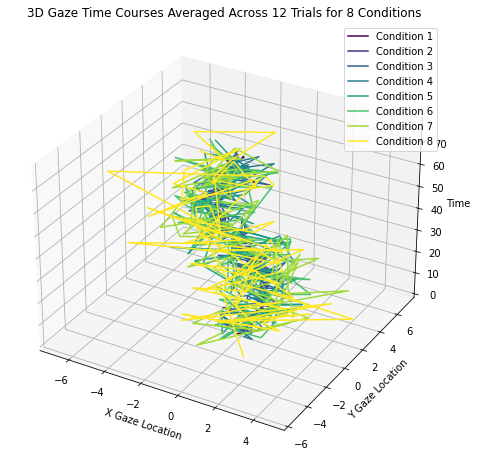

In [148]:
# Initialize arrays to hold the averaged gaze data for each condition
averaged_gaze = np.zeros((8, 80, 2))

# Calculate the averaged gaze time courses
for condition in range(8):
    condition_gaze_data = dataset[:, condition, :, :]
    averaged_gaze[condition] = np.mean(condition_gaze_data, axis=0)

# Define a color palette for the conditions
colors = plt.cm.viridis(np.linspace(0, 1, 8))

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for condition in range(8):
    x = averaged_gaze[condition][:, 0]
    y = averaged_gaze[condition][:, 1]
    z = np.arange(80)  # Time points from 0 to 7999
    ax.plot(x, y, z, color=colors[condition], label=f'Condition {condition + 1}')

ax.set_xlabel('X Gaze Location')
ax.set_ylabel('Y Gaze Location')
ax.set_zlabel('Time')
ax.set_title('3D Gaze Time Courses Averaged Across 12 Trials for 8 Conditions')
ax.legend()
ax.grid(True)

plt.show()

